In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Machine Learning – Group Project

### Team [24] – TBA

Members:
- Kristoffer Seyffarth |10476|
- Tobias Fremming |558892|
- Iver Ringheim [563862]

## Exploratory analisys

Must include 4 of these
* Search domain knowledge
* Check if the data is intuitive
* Understand how the data was generated
* Explore individual features
* Explore pairs and groups of features
* Clean up features

## Predictors

only one type of predictor is used (-3). To avoid the deduction, you should show that you have tried two or more types of predictors in the report (e.g., XGBoost and Random Forest). It is allowed to use only one type of predictor in a short notebook for Kaggle predictions.

### XGboost

#### Data
The data is preprocessed, and engineered. We generate a time_diff feature, which is the time to the next prediction. That way when generating training data, we can use the last known locational data, and set the time_diff to be the time difference from the last known to the estimated one. We do this for each vessel, and for a timestep with exponentially increasing length, so that we get most instances with a low timestep, and some with longer, making the model able to predict both short and long timesteps, however with an emphasis on the lower as those are the ones being scaled the most. 

When generating test data we do essentially the same, select the last known locational data, and insert the computed time difference. 

We noticed greatly increased accuracy when generating more training data. However we are hardware bound so we are not able to generate more training data. We also implemented a cap on the amount of training instances per vessel. This is because we noticed there were great variation between the amount of instances per vessel. In order not to overfit on any one vessel, and also save memory not creating uneccesary amounts of training instances for vessels with high amounts of references.

#### Model

We utilize the h2o library, which has an xgboost model built in. We have expenrienced multiple different confugurations and tested using grid search explained below, and landed on these parameters.

TODO- talk about and show model paraeters here

### Performance


### RandomForest
### Transformer

#### Data
Because of the seqential nature of data, the group also implemented a transformer model. It utilized the same data as the previus models, but including the whole sequence of features not just single instances. Furthermore the data also had to be transfered into three dimensional numpy arrays, and normalized. 

Because we encode latitude and longitude to sin and cosin values, we end up with 4 targets to predict. This is a drawback with the previus models, as each target had to be trained seperatly. With a sequential model we could predict all of them at once. 

#### Model

Below is a series of images illustrating the amount of layers, nodes, and transformer blocks used. Because of hardware restrictions, we had to limit the amount of trainable parameters to the minimum. Therefore we only utilized a low embedding dimension of 16, and 4 transformer blocks. This combined with a large amount of data, each epoc was about 12 minutes, and with 50 epocs about 10 hours to train on a 16 core cpu. Additionally the RAM required was about 44GB, which exceeds the limitations of this course. This combined with the dissapointing result is why this model is not one of the delivered ones. 

The input is the sequential features, together with the vesselID, and shippingLineId, which is used to create embedding vectores that is concatenated with the output from the transformer blocks, before the msp regression layers. 

d_model=16

model = build_transformer_model(

    sequence_length=sequence_length, #the previus points, set to 10 to save data

    num_features=num_features, 

    num_targets=num_targets,

    head_size=int(d_model/4), 

    num_heads=4,

    ff_dim=d_model*4,

    num_transformer_blocks=4,

    mlp_units=[d_model*4],

    d_model=d_model,

    num_vessels=750,

    vessel_embedding_dim=16,

    num_shipping_lines=30,

    shipping_embedding_dim=4,
    
    dropout=0.1,

    mlp_dropout=0.1,
)

We trained the model using 50 epocs, however early stopping was implemented so sometimes it finished earlier.

#### Performance
We experienced some initial success, with the lowest score on kaggle beeing 130. However this was extremely computationally expensive, as the dimension used was 64, resulting in about 500 000 parameters. It consistently achieved 150 for smaller models, and the predicted generally more realistic projections for each vessel, however still it got a worse score on kaggle.

Due to the computational expense to train the model, we were unable to perform major parameter tuning. This could also be the reson for the poor performance, as deep learning generally is more exposed to tuning and data generation than the models explained above. 

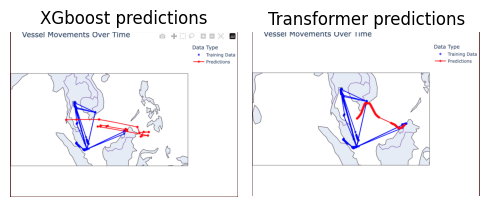

In [13]:
# Load images
img1 = mpimg.imread("images/predictions_xgboost.png")
img2 = mpimg.imread("images/predictions_transformer.png")

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 20))  # 4 rows, 1 column

# Display each image in a subplot
axs[0].imshow(img1)
axs[0].axis("off")  # Hide axes
axs[0].set_title("XGboost predictions")

axs[1].imshow(img2)
axs[1].axis("off")  # Hide axes
axs[1].set_title("Transformer predictions")


# Adjust layout
plt.tight_layout()
plt.show()

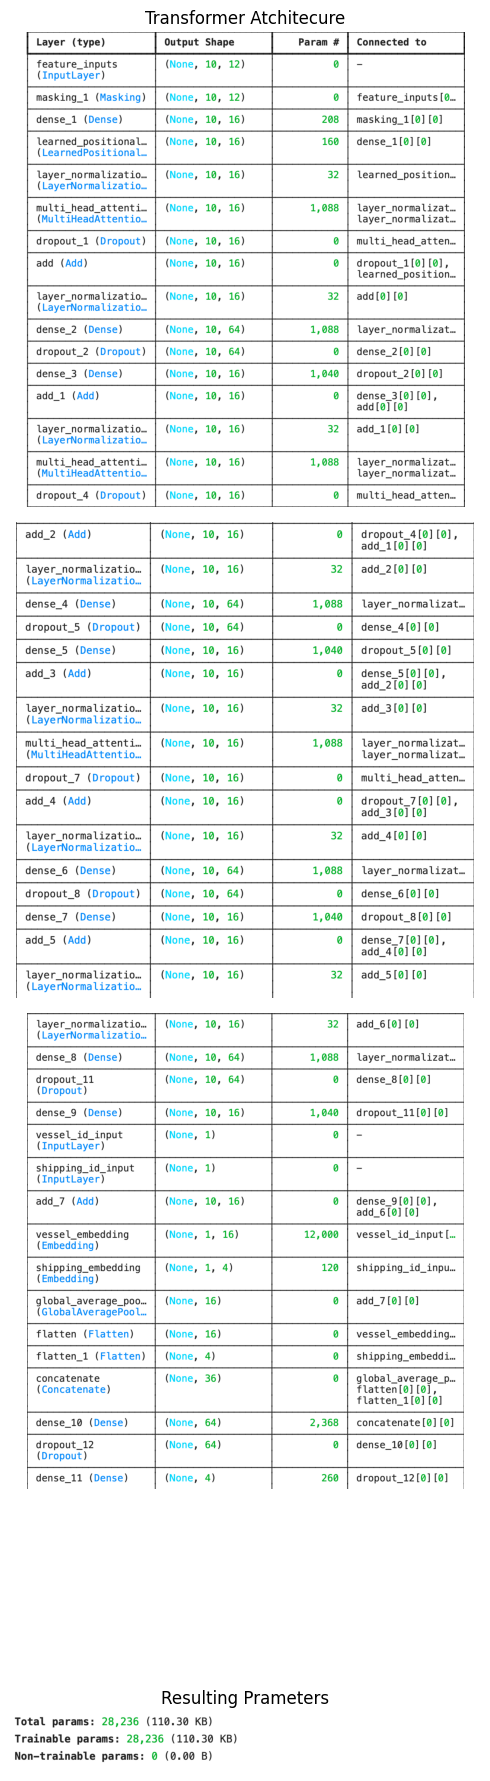

In [9]:
# Load images
img1 = mpimg.imread("images/transformer1.png")
img2 = mpimg.imread("images/transformer2.png")
img3 = mpimg.imread("images/transformer3.png")
img4 = mpimg.imread("images/transformer_params.png")  # Assuming you have a fourth image

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 20))  # 4 rows, 1 column

# Display each image in a subplot
axs[0].imshow(img1)
axs[0].axis("off")  # Hide axes
axs[0].set_title("Transformer Atchitecure")

axs[1].imshow(img2)
axs[1].axis("off")  # Hide axes

axs[2].imshow(img3)
axs[2].axis("off")  # Hide axes

axs[3].imshow(img4)
axs[3].axis("off")  # Hide axes
axs[3].set_title("Resulting Prameters")

# Adjust layout
plt.tight_layout()
plt.show()

## Feature Engineering

no feature engineering (-3). To avoid the deduction, you should show that you have tried one or more feature engineering techniques (i.e., feature selection and/or feature extraction) in the report.

### Encoding lat/long Rot Cog Heading Port_lat/Port_long 
We have encoded all circular data into sin and cosin values. This is because in order to preserve the rotational premice, that for example longitude -180 and 180 are essentially the same. Therefore we end up with almost twice as many features, but that makes it easier for the model to predict. We also do the encoding on the targets, meaning we predict lat and longitude sin and cosin, and revert it back to degrees after prediction.

### Cog and sog
We multiply sog with cog sin and cosin. This removes the need for a seperate sog feature, and instead utilize two directioannl velocity features.

### ETAraw to seconds_to_eta
The ETA raw is a feature of strings which required extensive preprocessing before generating timestamps from it. After preprocessing we generate seconds_to_eta which is the difference in seconds between the time feature and etaRAW. 

## time_diff
We also generate time_diff as a similar feature, which is the time difference from the current point to the next. This way when generating training and test data, you simply alter the time diff to reflect the time between each point and the one it is predicting for

## Model Interpretation

no model interpretation (-3). To avoid the deduction, you should show one or more model interpre- tation results (e.g., PDP, feature importance, LIME) in the report.